In [1]:
import ikpy
import sys
import numpy as np
from ikpy import plot_utils
from os.path import abspath
from pypot.creatures import PoppyTorso
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
sys.path.append('./sketchModel')
from sketch_pix2seq_sampling import getAbsoluteStrokes,drawAbsolutePosition

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [2]:
strokes = getAbsoluteStrokes('','','./sketchModel/outputs/snapshot','./200.png')


model_params.max_seq_len 129.



----------------------------------------------------------------------------------------------------
is_training: True
Model using gpu.
Input dropout mode = False.
Output dropout mode = False.
Recurrent dropout mode = True.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


-------------------------------------------------------------------

In [3]:
from pypot.vrep import remote_api,vrep_session_id
remote_api.simxFinish(-1)
scene_path = abspath('./vrep-sensors/torso_sensors_scene.ttt')
config_path = abspath('./vrep-sensors/torso_vrep_sensors_config.json')
#config_path = abspath('./config/torso_config_cam01.json')
poppy = PoppyTorso(simulator='vrep', scene=scene_path, config=config_path)
#poppy = PoppyTorso(config=config_path)

In [4]:
'''for motor in poppy.motors:
    print(motor.name)
    motor.compliant = True
    motor.goto_position(0, 3)
'''

'for motor in poppy.motors:\n    print(motor.name)\n    motor.compliant = True\n    motor.goto_position(0, 3)\n'

In [5]:
#poppy.bust_y.compliant = True

In [6]:
#poppy.r_elbow_y.goto_position(10.9,0.5)
#poppy.r_arm_z.goto_position(-45,0.5) #Angle, Time

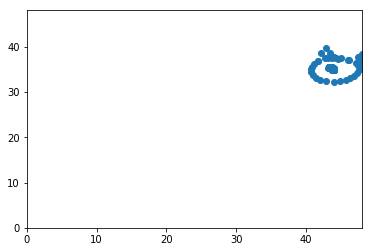

In [7]:
drawAbsolutePosition(strokes,(0,48,0,48))

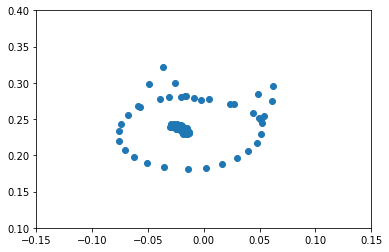

In [8]:
image_size = 0.15
x_bound_min = -0.15
y_bound_min = 0.10
bound_max = 0.30

def rescaleImage(strokes,init_size,end_size,xFactor, yFactor):
    new_stroke = []
    for stroke in strokes:
        x = end_size/(init_size/stroke[0])
        y = end_size/(init_size/stroke[1])
        new_stroke.append([x,y,stroke[2]])
    new_stroke = np.asarray(new_stroke)
    
    xMin = np.min(new_stroke[:,0])
    xMax = np.max(new_stroke[:,0])

    yMin = np.min(new_stroke[:,1])
    yMax = np.max(new_stroke[:,1])
    
    
    multiX = end_size/(xMax-xMin)
    multiY = end_size/(yMax-yMin)
    
    new_stroke[:,0] = new_stroke[:,0] * np.floor(multiX)
    new_stroke[:,1] = new_stroke[:,1] * np.floor(multiY)
    new_stroke = moveImage(new_stroke,xFactor,yFactor)
    return new_stroke

def moveImage(stroke_rescale, xFactor, yFactor):
    xMin = np.min(stroke_rescale[:,0])
    yMin = np.min(stroke_rescale[:,1])

    stroke_rescale[:,0] = (stroke_rescale[:,0] - (xMin * xFactor))
    stroke_rescale[:,1] = stroke_rescale[:,1] - (yMin * yFactor)
    return stroke_rescale

stroke_rescale = rescaleImage(strokes, 48, image_size,1.10, 0.70)
#print(stroke_rescale)
xMin = np.min(stroke_rescale[:,0])
xMax = np.max(stroke_rescale[:,0])

yMin = np.min(stroke_rescale[:,1])
yMax = np.max(stroke_rescale[:,1])
    
drawAbsolutePosition(stroke_rescale,(x_bound_min,x_bound_min+bound_max,y_bound_min, y_bound_min+bound_max))


# Limite de angulos en VREP

abs_z = -80, 80 <br>
bust_y = -46, 23 <br>
bust_x = -40 40 <br>
l_shoulder_y = -180, 150 <br>
l_shoulder_x = -105, 110 <br>
l_arm_z = -70, 90 <br>
l_elbow_y = -90, 90

# Posición del efector final

El calculo del efector final es computado a partir de las articulación de la cadena y la cinematica del robot
Representa una posición teorica el cual difiere de la real por imperfecciones del modelo.

In [9]:
def getEffector():
    effector = poppy.l_arm_chain.end_effector
    print("X : %.6f" % effector[0] + ", Y : %.6f" % effector[1] + ", Z : %.6f" % effector[2])
    return effector

# Posición de los angulos

Representa los valores de la articulación de la cadena expresado en angulos.

In [10]:
def getDegrees():
    nameMotors = [motor.name for motor in poppy.l_arm_chain.motors]
    mapped = zip(nameMotors, poppy.l_arm_chain.joints_position)
    for motorValue in mapped:
        print(motorValue)

In [11]:
def calc_difference(point,effector):
    result = [0,0,0]
    result[0] = abs(point[0]-effector[0])
    result[1] = abs(point[1]-effector[1])
    result[2] = abs(point[2]-effector[2])
    return result

def mov_poppy_arm(chain, umbral, point):
    iteration = 1
    effector = chain.end_effector
    diff = calc_difference(point, effector)
    while((diff[0] >= umbral[0] or diff[1] >= umbral[1] or diff[2] >= umbral[2]) and iteration <= 50):
        chain.goto((point[0], point[1], point[2]), 0.1, wait=True)
        time.sleep(0.1)
        effector = chain.end_effector
        diff = calc_difference(point, effector)
        iteration += 1
    return iteration

def diff_time(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [12]:
x_umbral = 0.002
y_umbral = 0.002
z_umbral = 0.002

umbral = (0.002, 0.002, 0.002)
umbral_without = (0.1, 0.01, 0.1)

# Dibujar gato

In [13]:
from pypot.vrep import remote_api,vrep_session_id
def draw_VREP_Point(points):
    res = remote_api.simxCallScriptFunction(vrep_session_id, 'Canvas', 
                                                remote_api.sim_scripttype_childscript, 'draw_point', 
                                                [], points, [], bytearray(), remote_api.simx_opmode_blocking)
def draw_VREP_Line(points):
    res = remote_api.simxCallScriptFunction(vrep_session_id, 'Canvas', 
                                            remote_api.sim_scripttype_childscript, 'draw_line', 
                                            [], points, [], bytearray(), remote_api.simx_opmode_blocking)

In [14]:

def drawWithPoppyPoint(planeY, withoutDraw, strokes):
    axisY = planeY
    stroke_i = 0
    umbralR = (0, 0, 0)
    size = len(strokes)
    position_draw_log = []
    position_without_draw_log = []
    position_total = []
    auxhandle = remote_api.simxGetObjectHandle(vrep_session_id, 'l_ball', remote_api.simx_opmode_blocking)
    position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_streaming)
    start = datetime.now()
    for stroke in strokes:
        if stroke[2] == 0:
            axisY = planeY
            umbralR = umbral
        else:
            axisY = withoutDraw
            umbralR = umbral_without
        i = mov_poppy_arm(poppy.l_arm_chain, umbralR, (stroke[0], axisY, stroke[1]))
        stroke_i += 1
        position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_buffer)
        if(axisY == planeY):
            position_draw_log.append(position[1])
            draw_VREP_Point([position[1][0],position[1][1]-0.04,position[1][2]])
        else:
            position_without_draw_log.append(position[1])
        position_total.append(position[1])
        print("Move %.d" % stroke_i + " from %.d" % size + " iterations to converge : %.d" % i)
    end = datetime.now()
    print("-----------------------------------------------")
    print(diff_time(start, end))
    mov_poppy_arm(poppy.l_arm_chain, umbral, (stroke[0], withoutDraw, stroke[1]))
    return position_total, position_draw_log, position_without_draw_log      
#position_total, position_draw_log, position_without_draw_log  = drawWithPoppy(-0.24, -0.13, stroke_rescale)

In [15]:
from collections import deque
def draw_line(queue):
    if(len(queue) != 2):
        return queue
    initial_point = queue.popleft()
    final_point = queue.popleft()
    line = np.asarray([initial_point,final_point]).flatten()
    draw_VREP_Line(line)
    return queue

In [16]:

    
def drawWithPoppyPoint(planeY, withoutDraw, strokes):
    axisY = planeY
    stroke_i = 0
    umbralR = (0, 0, 0)
    size = len(strokes)
    position_draw_log = []
    position_without_draw_log = []
    position_total = []
    auxhandle = remote_api.simxGetObjectHandle(vrep_session_id, 'l_ball', remote_api.simx_opmode_blocking)
    position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_streaming)
    start = datetime.now()
    for stroke in strokes:
        if stroke[2] == 0:
            axisY = planeY
            umbralR = umbral
        else:
            axisY = withoutDraw
            umbralR = umbral_without
        i = mov_poppy_arm(poppy.l_arm_chain, umbralR, (stroke[0], axisY, stroke[1]))
        stroke_i += 1
        position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_buffer)
        if(axisY == planeY):
            position_draw_log.append(position[1])
            draw_VREP_Point([position[1][0],position[1][1]-0.04,position[1][2]])
        else:
            position_without_draw_log.append(position[1])
        position_total.append(position[1])
        print("Move %.d" % stroke_i + " from %.d" % size + " iterations to converge : %.d" % i)
    end = datetime.now()
    print("-----------------------------------------------")
    print(diff_time(start, end))
    mov_poppy_arm(poppy.l_arm_chain, umbral, (stroke[0], withoutDraw, stroke[1]))
    return position_total, position_draw_log, position_without_draw_log      
#position_total, position_draw_log, position_without_draw_log  = drawWithPoppyPoint(-0.24, -0.13, stroke_rescale)

In [ ]:

    
def drawWithPoppyLine(planeY, withoutDraw, strokes):
    axisY = planeY
    stroke_i = 0
    line = deque()
    umbralR = (0, 0, 0)
    size = len(strokes)
    position_draw_log = []
    position_without_draw_log = []
    position_total = []
    auxhandle = remote_api.simxGetObjectHandle(vrep_session_id, 'l_ball', remote_api.simx_opmode_blocking)
    position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_streaming)
    start = datetime.now()
    for stroke in strokes:
        if stroke[2] == 0:
            axisY = planeY
            umbralR = umbral
        else:
            axisY = withoutDraw
            umbralR = umbral_without
        i = mov_poppy_arm(poppy.l_arm_chain, umbralR, (stroke[0], axisY, stroke[1]))
        stroke_i += 1
        position = remote_api.simxGetObjectPosition(vrep_session_id, auxhandle[1], -1, remote_api.simx_opmode_buffer)
        if(axisY == planeY):
            position_draw_log.append(position[1])
            line.append([position[1][0],position[1][1]-0.04,position[1][2]])
            if (len(line) == 2):
                draw_line(line)
                line.append([position[1][0],position[1][1]-0.04,position[1][2]])
        else:
            if(len(line) == 1):
                line.popleft()
            position_without_draw_log.append(position[1])
        position_total.append(position[1])
        #print("Move %.d" % stroke_i + " from %.d" % size + " iterations to converge : %.d" % i)
    end = datetime.now()
    print("-----------------------------------------------")
    print(diff_time(start, end))
    mov_poppy_arm(poppy.l_arm_chain, umbral, (stroke[0], withoutDraw, stroke[1]))
    return position_total, position_draw_log, position_without_draw_log      
position_total, position_draw_log, position_without_draw_log  = drawWithPoppyLine(-0.24, -0.13, stroke_rescale)

In [ ]:
position_draw_log = np.asarray(position_draw_log)
position_without_draw_log = np.asarray(position_without_draw_log)
position_total = np.asarray(position_total)
y_draw = position_draw_log[:,1]
print("VALUES FOR PENCIL DRAWING")
print("Low value : %.6f " % np.min(y_draw))
print("Mean draw: %.6f " % np.mean(y_draw))
print("Median draw: %.6f " % np.median(y_draw))
print("High value : %.6f " % np.max(y_draw))
print("Space of canvas  : %.6f " % (np.min(y_draw)-np.max(y_draw)))

print("----------------------------------------------------------")
print("VALUES FOR PENCIL WITHOUT DRAW")

y_without_draw = position_without_draw_log[:,1]
print("Low value : %.6f " % np.min(y_without_draw))
print("Mean without draw: %.6f " % np.mean(y_without_draw))
print("Median draw: %.6f " % np.median(y_without_draw))
print("High value : %.6f " % np.max(y_without_draw))
print("Space of canvas  : %.6f " % (np.min(y_without_draw)-np.max(y_without_draw)))



In [ ]:
mov_poppy_arm(poppy.l_arm_chain, umbral, (0 0, 0))

In [ ]:
print("Pencil up %.d" % np.sum(stroke_rescale[:,2]))
def plotAllData(output,save=False,name="Image"):
  plt.plot(np.arange(0,len(output),1),output[:,0],'go-',label='Axis X',c='r')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis X')
  if save:
    plt.savefig(name + "_Axis_X")
  plt.show()

  plt.plot(np.arange(0,len(output),1),output[:,1],'go-',label='Axis Y',c='b')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis Y')
  if save:
    plt.savefig(name + "_Axis_Y")
  plt.show()

  plt.plot(np.arange(0,len(output),1),output[:,2],'go-',label='Axis Z',c='c')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Output of axis Z')
  if save:
    plt.savefig(name + "_Axis_Z")
  plt.show()

#plotAllData(position_total)

/home/steven/.local/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/home/steven/.local/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)
/home/steven/.local/lib/python2.7/site-packages/IPython/nbconvert.py:13: ShimWarning: The `IPython.nbconvert` package has been deprecated since IPython 4.0. You should import from nbconvert instead.
  "You should import from nbconvert instead.", ShimWarning)
/home/steven/.local/lib/python2.7/site-packages/nbformat/current.py:75: UserWarning: reads_json is deprecated, use reads
  warnings.warn("reads_json is deprecated, use reads")


AttributeError: cells